<a href="https://colab.research.google.com/github/elianaprosnitz/bio108tutorial/blob/main/Week_10_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The impact of wildfires on threatened species richness in California**

This analysis explores the question of how wildfires in California are impacting the species richness, specifically the species richness of threatened species (as identified by the IUCN Red List). With the concering increase in CA wildfires, this exploration will shed light on how these disasters are impacting our most vulnerable species.

**QUESTION:**
Is there a relationship between 2024 threatened species richness and wildfire perimeters in Califonia?

First, import rasterio and necesary packages.

In [1]:
!pip install rasterio
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.4 MB/s eta 0:00:00


In [2]:
# Import packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import fiona

Connect to Google Drive to access downloaded files.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import .tif file for Combined Species Richness in 2025 from IUCN database.

In [4]:
SR_tif_path = '/content/drive/My Drive/Combined_THR_SR_2024/Combined_THR_SR_2024.tif'
SR_tif = rasterio.open(SR_tif_path)

Import .shp file for California State Boundary from data.gov database.


In [5]:
california_shp_path = "/content/drive/MyDrive/ca_state/CA_State.shp"
california_boundary = gpd.read_file(california_shp_path)

Import .shp file for California wildfires from California State geoportal.

In [6]:
CA_wildfire_shp_path = '/content/drive/My Drive/California_Fire_Perimeters_(all)/California_Fire_Perimeters_(all).shp'
CA_wildfire = gpd.read_file(CA_wildfire_shp_path)

Check the Coordinate Reference System (CRS) of raster data and shapefiles.

In [7]:
SR_tif.crs

CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [8]:
california_boundary.crs

<Projected CRS: PROJCS["Popular Visualisation CRS / Mercator",GEOG ...>
Name: Popular Visualisation CRS / Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
CA_wildfire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since the raster is in Mollweide projection, convert the California shapefiles from WGS 84 (lat/long) to match it.

*Side note: Reprojecting data is not simply to undo. This will be important later on.*

In [18]:
# Now we can reproject the CA shapefiles to match the Species Richness .tif
california_boundary = california_boundary.to_crs(SR_tif.crs)
CA_wildfire = CA_wildfire.to_crs(SR_tif.crs)

Plot the global species richness raster data and the CA boundary to see if it matches up and makes sense.

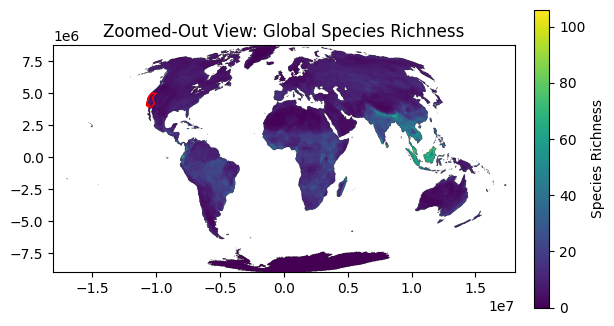

In [19]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")

#title plot
ax.set_title("Zoomed-Out View: Global Species Richness")

#Add a colorbar/legend to understand Species Richness
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

Zoom in on the area of interest: California. To do this, define the bounding box to the bounds of the California state shapefile.

In [13]:
#Define bounds for zoomed in plot
minx, miny, maxx, maxy = california_boundary.total_bounds

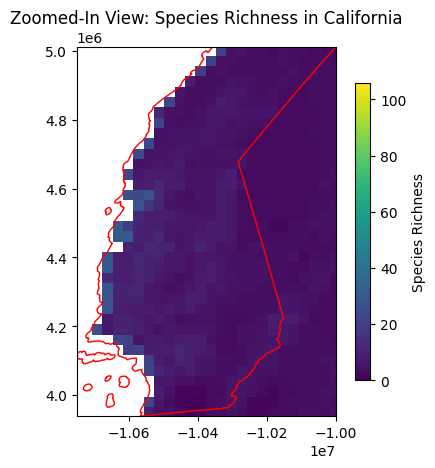

In [14]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")

# Set extent (zoom into California)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# title plot
ax.set_title("Zoomed-In View: Species Richness in California")

# SR colorbar
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

Add the fire perimeter data onto the plot. I made the fire area transparent so as to still see the SR information beneath.

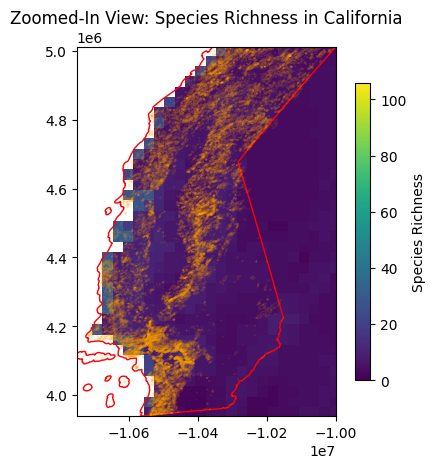

In [15]:
fig, ax = plt.subplots()
rasterio.plot.show(SR_tif, ax=ax)
california_boundary.plot(ax=ax, edgecolor="red", facecolor="none")
CA_wildfire.plot(ax=ax, edgecolor="orange", alpha = 0.1, facecolor="none")

# Set extent (zoom into California)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Labels
ax.set_title("Zoomed-In View: Species Richness in California")

# SR colorbar
img = rasterio.plot.show(SR_tif, ax=ax, cmap="viridis")
cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Species Richness")

plt.show()

**Results:** There doesn't appear to be any obvious correlation between threatened species richness and fire zones in CA. There may be some decrease closer to the coasts.


If I were to perform this analysis again, I would alter the following:
*   Higher resolution species richness data for state level analysis
*   Convert raster data to lat/long instead of changing the shapefile (the use of a projection CRS likely accounts for the obvious distortion of state)
*   Actually clip the raster data to the shape of California, instead of just zooming into it. Likely would make furthur correlation analyses more seamless.
*   More carefully/intentionally associate the year the species richness data comes from and the year of wildfire data.










**New Week 10 analyses**

Let's import high resolution species richness data for California. We'll draw from a massive dataset on the distribution of overall species biodiversity in California for the California Department of Fish and Wildlife’s (CDFW) Areas of Conservation Emphasis Project (ACE). This new data focuses on Terrestrial Rare Species Richness in California (last updated July 2024). Data points are organized into hexagonal pixels of the state, and each hexagon has rare species observation counts attached to it.

In [24]:
# URL to the ArcGIS GeoJSON
CA_SR_url = "https://data-cdfw.opendata.arcgis.com/api/download/v1/items/927417af9e694ad98c37a544da263db0/geojson?layers=0"

# Read the data into a GeoDataFrame
CA_SR = gpd.read_file(CA_SR_url)

# Show a preview
print(CA_SR.head())

   OBJECTID  Hex_ID  RarRankEco  RarSumEco  RarRankSW  RarSumSW  RareCount  \
0         1   49911           2   0.076475          2  0.037024          1   
1         2   11108           1   0.093609          3  0.085499          4   
2         3    7310           1   0.027228          1  0.007749          1   
3         4   39283           3   0.164931          3  0.089530          4   
4         5   36456           2   0.074071          2  0.041399          2   

   RarAmph  RarRept  RarBird  RarMamm  RarPlnt Eco_Sect  \
0        0        1        0        0        0     322A   
1        1        0        2        0        1     263A   
2        0        0        0        0        1     342B   
3        0        1        2        1        0     262A   
4        0        0        1        1        0     262A   

                       Eco_Name Jepson_Eco          County   Shape__Area  \
0                 Mojave Desert       DMoj  SAN BERNARDINO  9.626416e+06   
1     Northern Californi

Look at the summary statistics to see what might be useful to visualize. It is also useful to look at the metadata assosiated with the data. Check out the [Rare Species Richness Factsheet](https://data.ca.gov/dataset/terrestrial-rare-species-richness-summary-ace-ds2709/resource/01485d2f-b0b1-4039-82cf-b039bc53d4cd).

In [26]:
#Summary statistics
CA_SR.describe()

,OBJECTID,Hex_ID,RarRankEco,RarSumEco,RarRankSW,RarSumSW,RareCount,RarAmph,RarRept,RarBird,RarMamm,RarPlnt,Shape__Area,Shape__Length
count,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,63890.000000,6.389000e+04,63890.000000
mean,31945.500000,32273.305337,2.611989,0.171655,2.646032,0.095921,5.029394,0.454907,0.531069,1.630913,0.629285,1.783221,1.014504e+07,11866.115099
std,18443.598686,18587.250939,1.609954,0.159234,1.617746,0.102703,5.354898,0.824090,0.991147,2.241537,1.059061,2.875950,1.168902e+06,759.240561
min,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.251953e+01,20.890604
25%,15973.250000,16172.250000,1.000000,0.054916,1.000000,0.026605,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.652415e+06,11569.292534
50%,31945.500000,32316.500000,3.000000,0.127572,3.000000,0.063629,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.010348e+07,11838.181935
75%,47917.750000,48370.750000,4.000000,0.248276,4.000000,0.133285,7.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.082069e+07,12251.373882
max,63890.000000,64482.000000,5.000000,1.000000,5.000000,1.000000,61.000000,6.000000,9.000000,30.000000,11.000000,43.000000,1.173120e+07,23882.790090


According to the fact sheet, "RarRankSW" (Rare Rank State Wide) ranks hexagons from 1-5 assigned to the statewide normalized rare species richness values, with all zero values removed and remaining values broken into 5 quantiles, each containing the same number of hexagons.

We can make a heatmap of the data.

<Axes: >

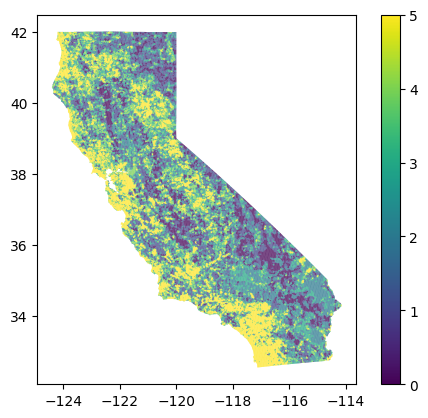

In [29]:
#Visualize the data
CA_SR.plot(column='RarRankSW', legend=True)

Before we add in our wildfire data, let's check to see if the CRS's are compatable.

In [35]:
CA_SR.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
CA_wildfire.crs

<Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Uh oh! Remember we reprojected the wildfire data into Mollweide CRS. Let's reimport our wildfire data in the original CRS.

In [41]:
#Reimport. You can use the same file path.
CA_wildfire_origCRS = gpd.read_file(CA_wildfire_shp_path)

#Check if it worked to reset CRS.
CA_wildfire_origCRS.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

HOWEVER, note that the CRS's are still not the same. The wildfire data (CA_wildfire) is in EPSG:3857 (a projected CRS), and the species richness data (CA_SR) is in EPSG:4326 (a geographic CRS). Let's convert the wildfire data into EPSG:4326 to match our base layer.

In [45]:
CA_wildfire_geographic = CA_wildfire_origCRS.to_crs(epsg=4326)

Now we can visualize the species richness and wildfire data on the same plot.

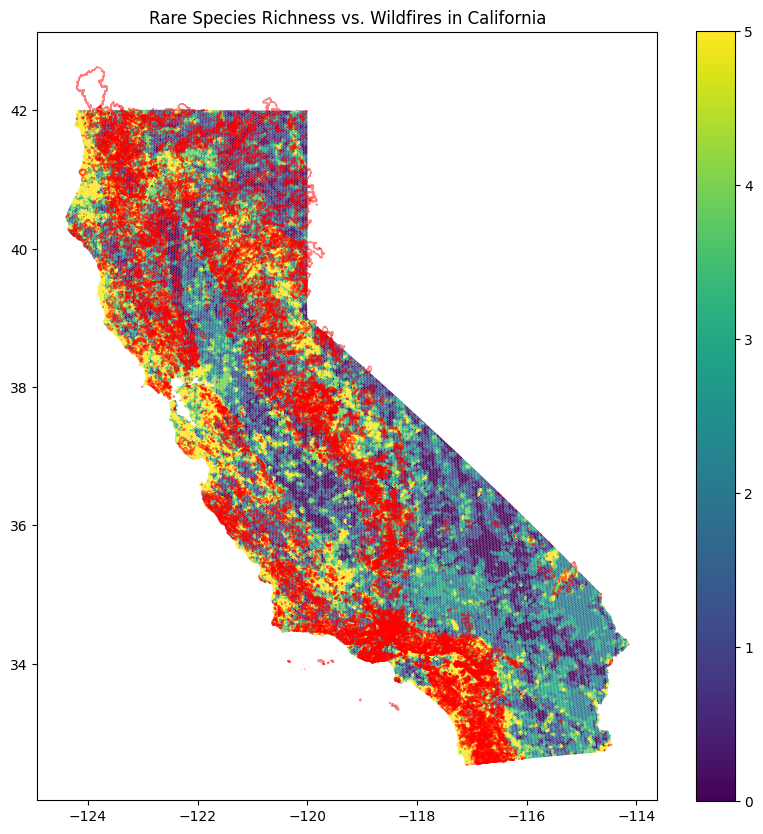

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

# Base layer: Species Richness hexagons
CA_SR.plot(column='RarRankSW', ax=ax, legend=True)

# Overlay: Wildfire data
CA_wildfire_geographic.plot(ax=ax, edgecolor="red", alpha = 0.5, facecolor="none")

# Title
ax.set_title("Rare Species Richness vs. Wildfires in California")

plt.show()

It's a bit hard to see the species richness data underneath the wildfire data. Let's put the two plots side by side to see our results more clearly.

In [ ]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

# Shared style settings
vmin = CA_SR['RarRankSW'].min()
vmax = CA_SR['RarRankSW'].max()

# Left: Base layer only
CA_SR.plot(
    column='RarRankSW',
    ax=ax1, vmin=vmin, vmax=vmax
)
ax1.set_title("Rare Species (Base Layer Only)")
ax1.set_axis_off()

# Right: Base layer and wildfire data
CA_SR.plot(
    column='RarRankSW',
    ax=ax2, vmin=vmin, vmax=vmax
)
CA_wildfire_geographic.plot(ax=ax2, facecolor='red', edgecolor='red', alpha = 0.5, linewidth=1)
ax2.set_title("Rare Species + Wildfire Overlay")
ax2.set_axis_off()

plt.tight_layout()
plt.show()

**Secondary results:**

Upon first glance, it appears that there is a positive correlation between wildfires and species richness. Correlation (famously) does not mean causation. It could be that there is higher species richness in regions more susceptible to fire danger. However, it could also reflect that wildfires promote habitat diversity and regeneration.

Next steps:
*   See if there is a way to statistically analyze the overlapped area and see the percentage breakdown of Rare Species Rank SW.
*   Check out individual species heatmaps agaisnt wildfire perimeters to see if there is interspecies variation.

[Terrestrial Rare Species Richness Summary - ACE](https://data.ca.gov/dataset/terrestrial-rare-species-richness-summary-ace-ds2709)



*Old brainstorm, just saving it in case I want to return to this.*



Below are some brainstormed attempts to clip the raster species richness data using the vector CA shapefile. I couldn't quite get it to work out.

In [ ]:
with fiona.open(california_shp_path, "r") as f:
    shapes = [feature["geometry"] for feature in f]

In [ ]:
out_image, out_transform = rasterio.mask.mask(SR_tif, shapes, crop=True)

Clip Species Richness data to just the state of California. New raster defined as CASR (California Species Richness).

In [ ]:
CASR_meta = SR_tif.meta.copy()
CASR_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    }
)

In [ ]:
with rasterio.open("Combined_THR_SR_2024_clip.tif", "w", **CASR) as dst:
    dst.write(out_image)

<Axes: >

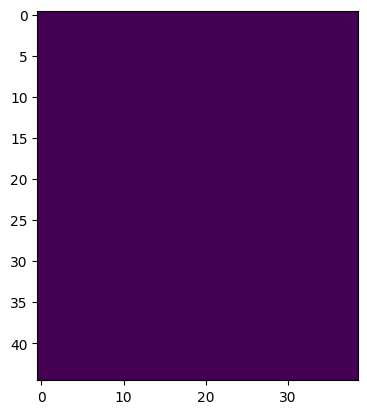

In [ ]:
fig, ax = plt.subplots()
rasterio.plot.show(out_image, ax=ax)